# Experiment steps
`goal`
1. 特徵簡單前處理後全部丟進 XGBoost 訓練，看 `v1` 模型成果
2. 將 feature importance 高的 feature set，做特徵轉換等 feature fusion，訓練 `v2` 模型
3. 區分不同可能高房價的情境，做變數觀察挑選變數進模型實驗，做出合理的因果結論
    * 欄位分析
    * 關聯性分析

In [255]:
import pandas as pd
import numpy as np
import re
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, 
                             precision_recall_curve, 
                             average_precision_score, 
                             mean_squared_error)

In [237]:
lists = pd.read_csv('csv/listings.csv')
lists.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# preprocessing

* 將 Y (price) type 轉為 integer

In [238]:
def remove_unused_char(price):
    return re.sub(r'(\$|,|\.00)', '', price)

Y = lists['price'].apply(lambda x: remove_unused_char(x)).astype('int32').reset_index(drop=True)

* 掌握 Y 的分佈，選定2成資料為高房價 (threshold >= `2857`) 將 Y 轉為類別型

In [239]:
print(' Y percentile:')
print(Y.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
Y_categ = pd.cut(Y, bins=[min(Y)-1, 2857, max(Y)], labels=[0, 1]).cat.codes
print('\n category Y value distribution')
Y_categ.value_counts()

 Y percentile:
0.1       580.0
0.2       800.0
0.3      1000.0
0.4      1229.0
0.5      1490.0
0.6      1754.8
0.7      2143.0
0.8      2857.0
0.9      4229.4
1.0    300245.0
Name: price, dtype: float64

 category Y value distribution


0    4212
1    1047
dtype: int64

 * 取出類別特徵，只要不是很離散 (distinct count <= 100)，就採用進 v1 模型   
 * 數值特徵，直接進 v1 模型

In [240]:
X = lists.drop(['price'], axis=1)
obj_col = X.dtypes[X.dtypes == np.object].index

remove_col = X[obj_col].nunique() > 100  # Remove column as unique value greater than 100
remove_col = remove_col.index[remove_col]
print(' Remove columns:')
print(remove_col)
X = X.drop(remove_col, axis=1).reset_index(drop=True)

 Remove columns:
Index(['listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_thumbnail_url', 'host_picture_url',
       'host_verifications', 'neighbourhood', 'amenities', 'first_review',
       'last_review'],
      dtype='object')


 * 類別轉數值

In [241]:
def category_to_num(df):
    df = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'bool' or x.dtype == 'object' else x)
    return df

X = category_to_num(X)
X

,id,scrape_id,last_scraped,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,74641,20210330225037,0,393116,-1,-1,0,0,0,4.0,...,10.0,9.0,9.0,NaN,0,2,0,2,0,0.43
1,178036,20210330225037,0,851825,0,0,1,0,1,9.0,...,10.0,10.0,10.0,NaN,1,9,0,1,1,0.69
2,271733,20210330225037,0,242033,1,0,1,1,2,0.0,...,10.0,10.0,10.0,NaN,0,1,1,0,0,0.57
3,289296,20210330225037,1,1338052,0,0,2,1,3,4.0,...,10.0,10.0,9.0,NaN,0,2,2,0,0,0.32
4,289298,20210330225037,0,1338052,0,0,2,1,3,4.0,...,10.0,10.0,9.0,NaN,0,2,2,0,0,1.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,48846513,20210330225037,2,9544894,0,15,1,0,-1,2.0,...,NaN,NaN,NaN,NaN,0,2,2,0,0,NaN
5255,48853952,20210330225037,1,102493558,0,0,1,1,3,2.0,...,NaN,NaN,NaN,NaN,0,2,1,0,1,NaN
5256,48854439,20210330225037,1,221534550,1,41,10,0,11,42.0,...,NaN,NaN,NaN,NaN,0,42,42,0,0,NaN
5257,48855237,20210330225037,1,298910458,0,1,12,1,0,7.0,...,NaN,NaN,NaN,NaN,0,4,4,0,0,NaN


# Split train and test data

In [242]:
def _split(data, ratio=0.9, seed=0):
    train, valid = train_test_split(
        data, train_size=ratio, random_state=seed
    )
    return train, valid

train, valid = _split(pd.concat([X, Y], axis=1), ratio=0.9)
train_categY, valid_categY = _split(pd.concat([X, Y_categ], axis=1), ratio=0.9)

# category Y
X_train_categY = train_categY.iloc[:, :-1]
X_test_categY = valid_categY.iloc[:, :-1]
y_train_categY = train_categY.iloc[:, -1]
y_test_categY = valid_categY.iloc[:, -1]

# numerical Y
X_train = train.iloc[:, :-1]
X_test = valid.iloc[:, :-1]
y_train = train.iloc[:, -1]
y_test = valid.iloc[:, -1]

# Train v1 model by XGBClassfier

In [243]:
# Train
xgbc = xgb.XGBClassifier(eval_metric='error')
xgbc.fit(X_train_categY, y_train_categY)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [244]:
# Predict
y_prob = xgbc.predict_proba(X_test_categY)[:,1]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [245]:
# Evaluation
auc = roc_auc_score(y_test_categY, y_prob)
auc

0.9664452393118719

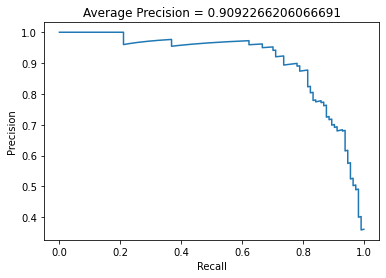

In [246]:
precision_list, recall_list, _ = precision_recall_curve(y_test_categY, y_prob)
plt.plot(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision = ' + str(average_precision_score(y_test_categY, y_prob)))
plt.show()
plt.close()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


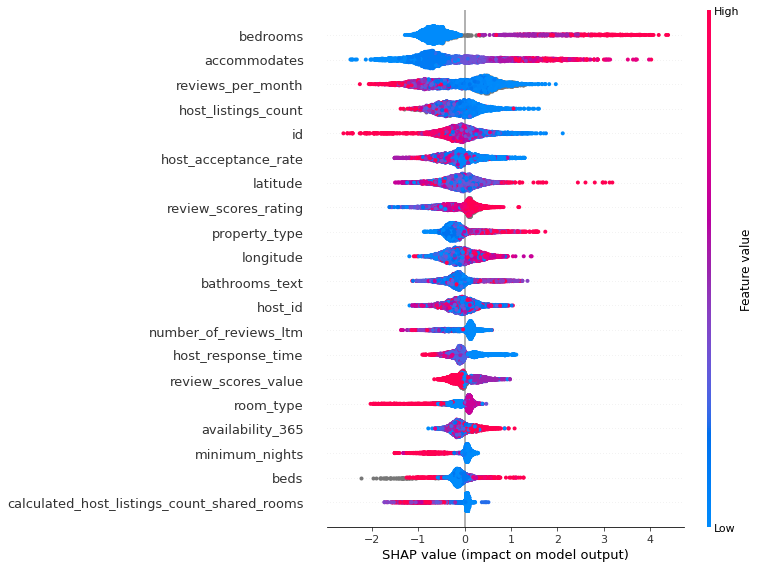

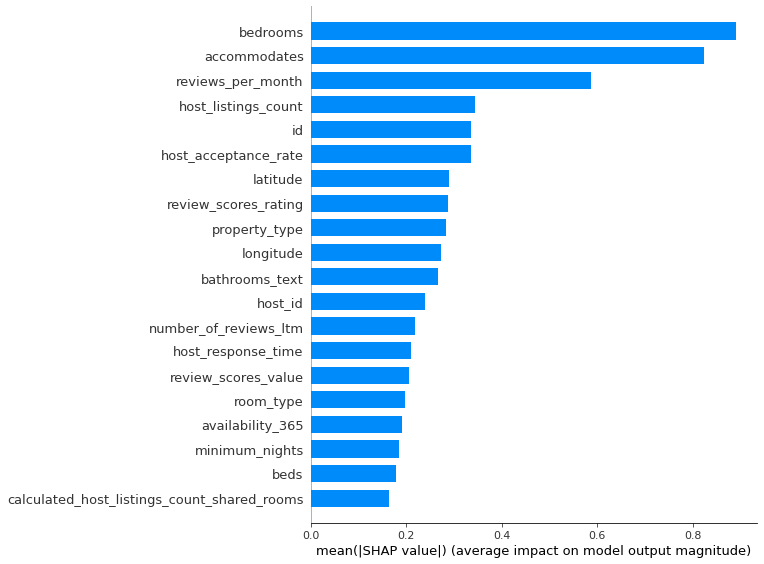

In [247]:
# feature importance
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_train_categY)
shap.summary_plot(shap_values, X_train_categY, max_display=20)
shap.summary_plot(shap_values, X_train_categY, max_display=20, plot_type="bar")

# Train v1 model by XGBRegressor

In [259]:
xgbr = xgb.XGBRegressor(eval_metric='error')
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='error',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [260]:
y_pred = xgbr.predict(X_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [267]:
train_mse = np.sqrt(mean_squared_error(y_test, y_pred))
train_mse

3965.4951396491656

# V1 模型結論
1. 